In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scripts.eas_lists import OsoData
from scripts.oso_db import execute_query
from scripts.processing import (
    github_event_processor, 
    github_active_developers, 
    github_repos_analysis,
    github_network_graph
)

from visualizations.contribution_heatmap import contribution_heatmap
from visualizations.network_graph import network_graph
from visualizations.stacked_area import activity_plot
from visualizations.venn_diagram import venn3_diagram


DPI = 144 # high res viz; looks best at 300
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
OP_RED = "#FF0420"

# Fetch / update data

In [2]:
DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

RPGF2_DATE = '2023-04-01'
START_DATE = '2015-01-01'
END_DATE = '2023-10-01'

In [162]:
oso = OsoData(DATA_PATH)
individuals = list(oso.df[oso.df['Applicant Type'] == 'INDIVIDUAL']['Slug: Primary'].values)
slugs = [s for s in oso.get_project_slugs() if s not in individuals]

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


In [163]:
# create a mapping of projects to collections
query = """
    SELECT p."slug", c."slug" 
    FROM project p 
    JOIN collection_projects_project cpp ON p."id" = cpp."projectId"
    JOIN collection c ON cpp."collectionId" = c."id"
    """
result = execute_query(query, col_names=False)
cpp = {k: sorted([v for v, key in result if key == k]) for k in set(key for _, key in result)}

# Visualize dataset coverage

Total projects: 366


(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

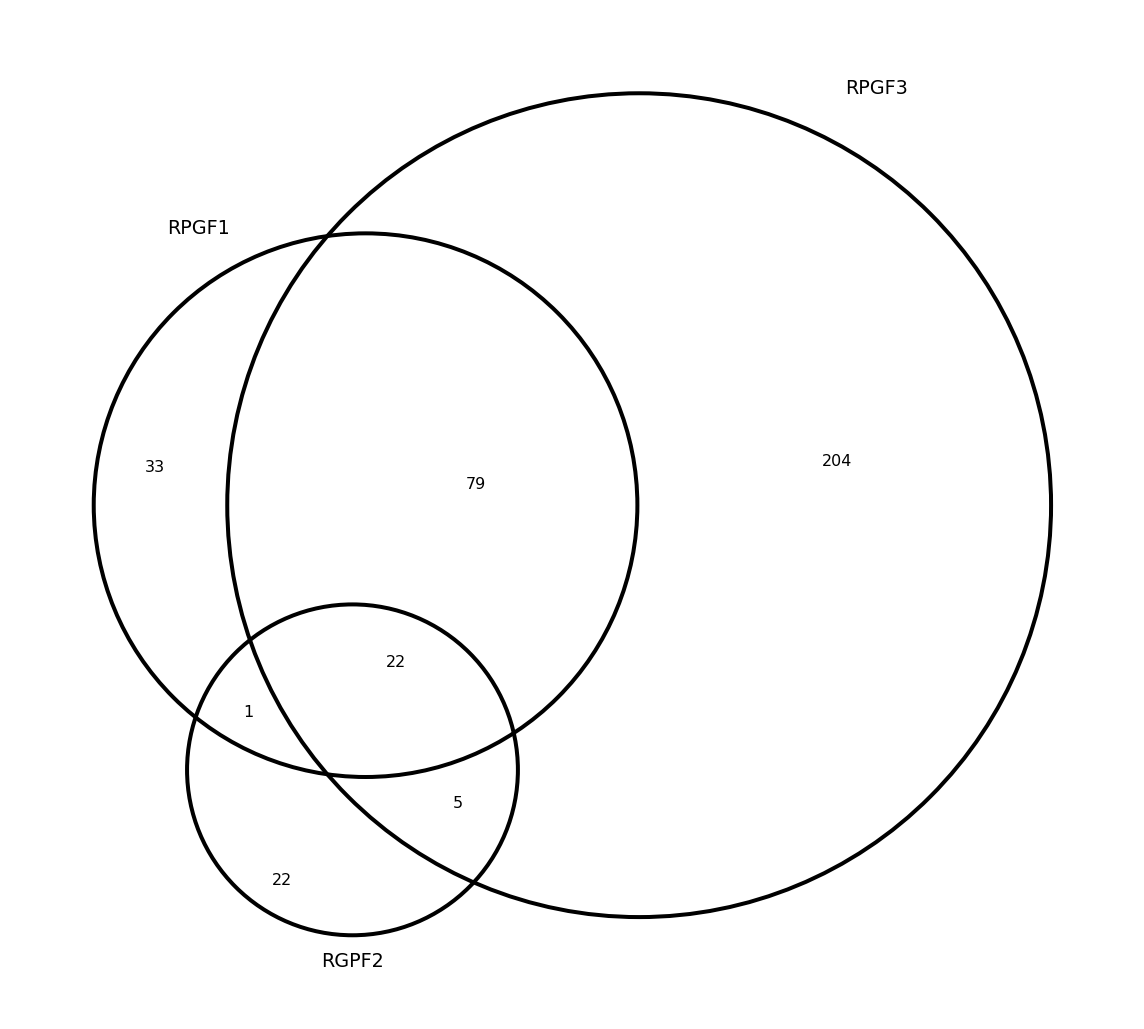

In [164]:
collection_slugs = ["op-rpgf1", "op-rpgf2", "op-rpgf3"]
all_slugs = set([p for c,ps in cpp.items() if c in collection_slugs for p in ps])
total_projects = len(all_slugs)
print("Total projects:", total_projects)

venn3_diagram(
    [set(ps) for c,ps in cpp.items() if c in collection_slugs], 
    ["RPGF1", "RPGF3", "RGPF2"]
)

# Developer Activity

In [165]:
def annualize_ticks(dataframe, ax):
    months = dataframe['month'].nunique()
    ax.set_xlim([0,months-1])
    ax.set_xticks([x for x in range(0,months,12)])
    xticklabels = [x[:-3] for x in sorted(df_devs['month'].unique())[::12]]
    ax.set_xticklabels(xticklabels)
        
def dev_activity_graph(dataframe, title, annual_ticks=True):
    fig, ax = plt.subplots(figsize=(8,4.5), dpi=144, facecolor='white')
    dataframe.groupby('month')['sum'].sum().plot(kind='area', ax=ax, color=OP_RED)
    if annual_ticks:
        annualize_ticks(dataframe, ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title, fontweight="bold", loc='left')

In [185]:
slugs_param = "','".join(slugs)

devs_query = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "active_developer"
                FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 4 -- COMMIT CODE EVENTS ONLY
            AND p.slug IN ('{slugs_param}')
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("active_developer")
    FROM Devs
    WHERE month >= '{START_DATE[:-3]}' AND month < '{END_DATE[:-3]}'
    GROUP BY slug, month
    ORDER BY slug DESC, month;
""", col_names=True)

df_devs = pd.DataFrame(devs_query[1:], columns=devs_query[0])
df_devs.head()

slug    month  sum
0  zora  2015-01    6
1  zora  2015-02    7
2  zora  2015-03    5
3  zora  2015-04    7
4  zora  2015-05    5

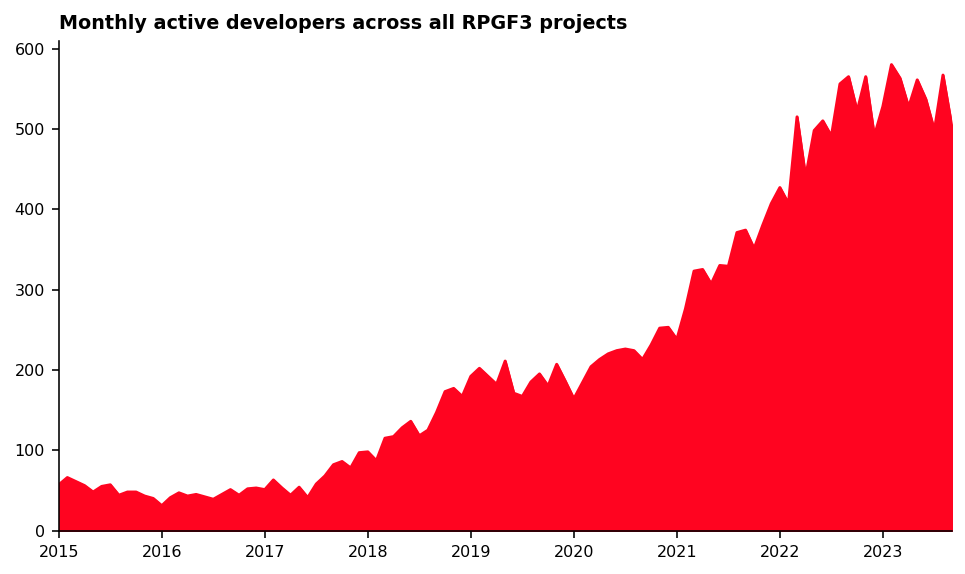

In [170]:
dev_activity_graph(df_devs, 'Monthly active developers across all RPGF3 projects')

Text(0.0, 1.0, 'Breakdown of monthly active developers by RPGF2/3 cohort')

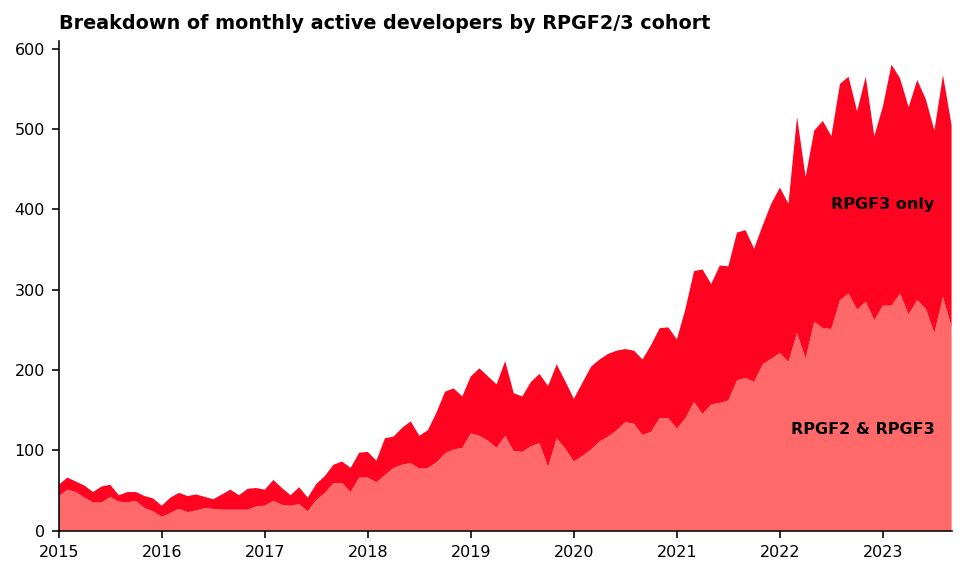

In [171]:
df_devs['in_rpgf2'] = df_devs['slug'].isin(cpp['op-rpgf2'])
pvt_devs = df_devs.pivot_table(
    index='in_rpgf2', 
    columns='month', 
    values='sum', 
    aggfunc='sum', 
    fill_value=0
)
fig, ax = plt.subplots(figsize=(8,4.5), dpi=144, facecolor='white')
ax.stackplot(
    pvt_devs.columns, 
    pvt_devs.loc[True], 
    pvt_devs.loc[False],
    colors=["#FF6969",  OP_RED]
)
annualize_ticks(df_devs, ax)
ax.text(s='RPGF2 & RPGF3', x=102, y=120, ha='right', fontweight='bold')
ax.text(s='RPGF3 only', x=102, y=400, ha='right', fontweight='bold')
ax.set_title('Breakdown of monthly active developers by RPGF2/3 cohort', fontweight="bold", loc='left')

In [186]:
all_slugs_param = "','".join([s for s in all_slugs if s not in individuals])

all_devs_query = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "active_developer"
                FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 4 -- COMMIT CODE EVENTS ONLY
            AND p.slug IN ('{all_slugs_param}')
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("active_developer")
    FROM Devs
    WHERE month >= '{START_DATE[:-3]}' AND month < '{END_DATE[:-3]}'
    GROUP BY slug, month;
""", col_names=True)

df_all_devs = pd.DataFrame(all_devs_query[1:], columns=all_devs_query[0])

def assign_tag(p):
    in_rpgf3 = p in cpp['op-rpgf3']
    in_rpgf2 = p in cpp['op-rpgf2']
    if in_rpgf3:
        if in_rpgf2:
            return "RPGF2 & RPGF3"
        else:
            return "RPGF3 only"
    return "Previous RPGFs"

df_all_devs['tag'] = df_all_devs['slug'].apply(assign_tag)
df_all_devs.head()

slug    month  sum         tag
0  zora  2015-01    6  RPGF3 only
1  zora  2015-02    7  RPGF3 only
2  zora  2015-03    5  RPGF3 only
3  zora  2015-04    7  RPGF3 only
4  zora  2015-05    5  RPGF3 only

Text(0.0, 1.0, 'Breakdown of monthly active developers by all RPGF cohorts')

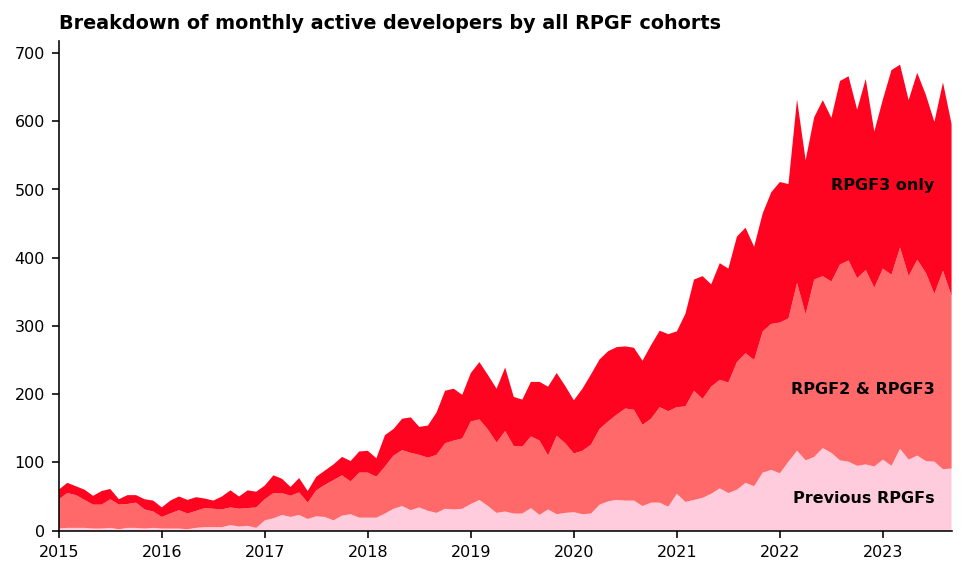

In [187]:
pvt_all_devs = df_all_devs.pivot_table(
    index='tag', 
    columns='month', 
    values='sum', 
    aggfunc='sum', 
    fill_value=0
)
fig, ax = plt.subplots(figsize=(8,4.5), dpi=144, facecolor='white')
ax.stackplot(
    pvt_all_devs.columns, 
    pvt_all_devs.loc["Previous RPGFs"], 
    pvt_all_devs.loc["RPGF2 & RPGF3"],
    pvt_all_devs.loc["RPGF3 only"],
    colors=["#FFCCDD", "#FF6969",  OP_RED]
)
annualize_ticks(df_devs, ax)
ax.text(s='Previous RPGFs', x=102, y=40, ha='right', fontweight='bold')
ax.text(s='RPGF2 & RPGF3', x=102, y=200, ha='right', fontweight='bold')
ax.text(s='RPGF3 only', x=102, y=500, ha='right', fontweight='bold')
ax.set_title('Breakdown of monthly active developers by all RPGF cohorts', fontweight="bold", loc='left')

In [188]:
df_all_devs[df_all_devs['tag'] == 'Previous RPGFs']['slug'].nunique()

55

In [189]:
df_all_devs[df_all_devs['tag'] == 'Previous RPGFs'].groupby('slug')['sum'].mean().sort_values().tail(3)

slug
walletconnect     5.913580
safe-global       7.426667
code-423n4       15.023810
Name: sum, dtype: float64

Text(0.0, 1.0, 'Change in developer activity 6 months before vs 6 months after RPGF2')

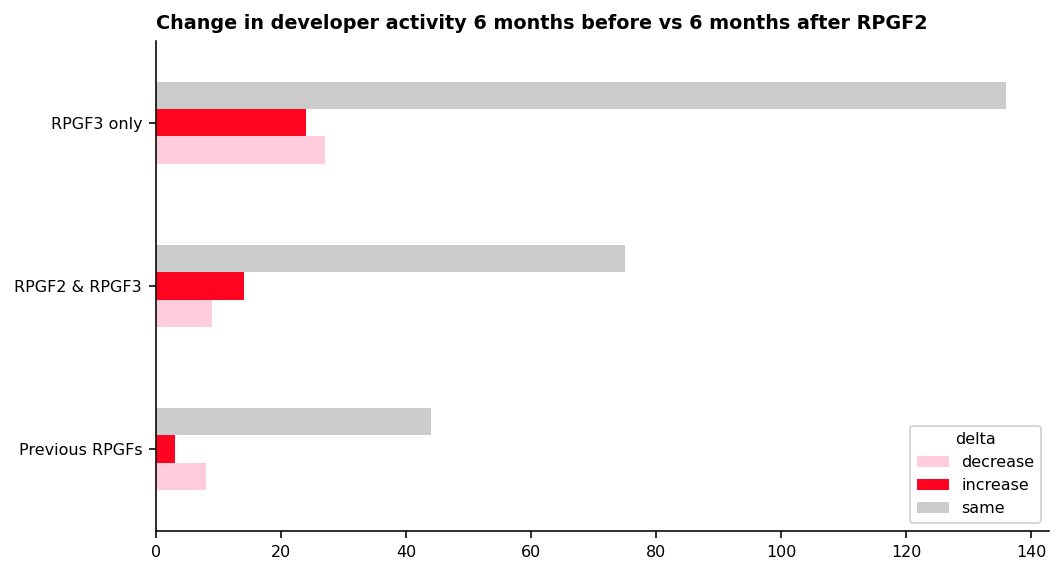

In [190]:
pvt_months = df_all_devs.pivot_table(
    index=['tag', 'slug'], 
    columns='month', 
    values='sum', 
    aggfunc='mean', 
    fill_value=0
).iloc[:,-12:]
before = pvt_months.iloc[:,:6].mean(axis=1).rename("before")
after = pvt_months.iloc[:,6:].mean(axis=1).rename("after")

ba_df = pd.concat([before, after], axis=1)

def assign_delta(b, a):
    if abs(b-a) < 1:
        return "same"
    if not b or not a:
        if b:
            return "decrease"
        return "increase"
    if abs(b-a) / b < .1:
        return "same"
    if b > a:
        return "decrease"
    return "increase"
    
ba_df['delta'] = ba_df.apply(lambda x: assign_delta(x['before'], x['after']), axis=1)


fig, ax = plt.subplots(figsize=(8,4.5), dpi=144, facecolor='white')
ba_df.reset_index().groupby(['tag', 'delta'])['slug'].count().unstack().plot(
    kind='barh', 
    ax=ax,
    color=["#FFCCDD", OP_RED, "#CCC"]
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Change in developer activity 6 months before vs 6 months after RPGF2", fontweight="bold", loc='left')

In [192]:
contribution_heatmap(
    df_all_devs.sort_values(by='slug'),
    index_col='slug',
    column_col='month',
    value_col='sum',
    apply_groupby=True,
    sort_label_method='mean',
    dpi=300,
    cmap='Reds'
)

(<Figure size 6300x20400 with 1 Axes>, <AxesSubplot:>)

# "Leaderboard"

(<Figure size 3024x2880 with 1 Axes>, <AxesSubplot:>)

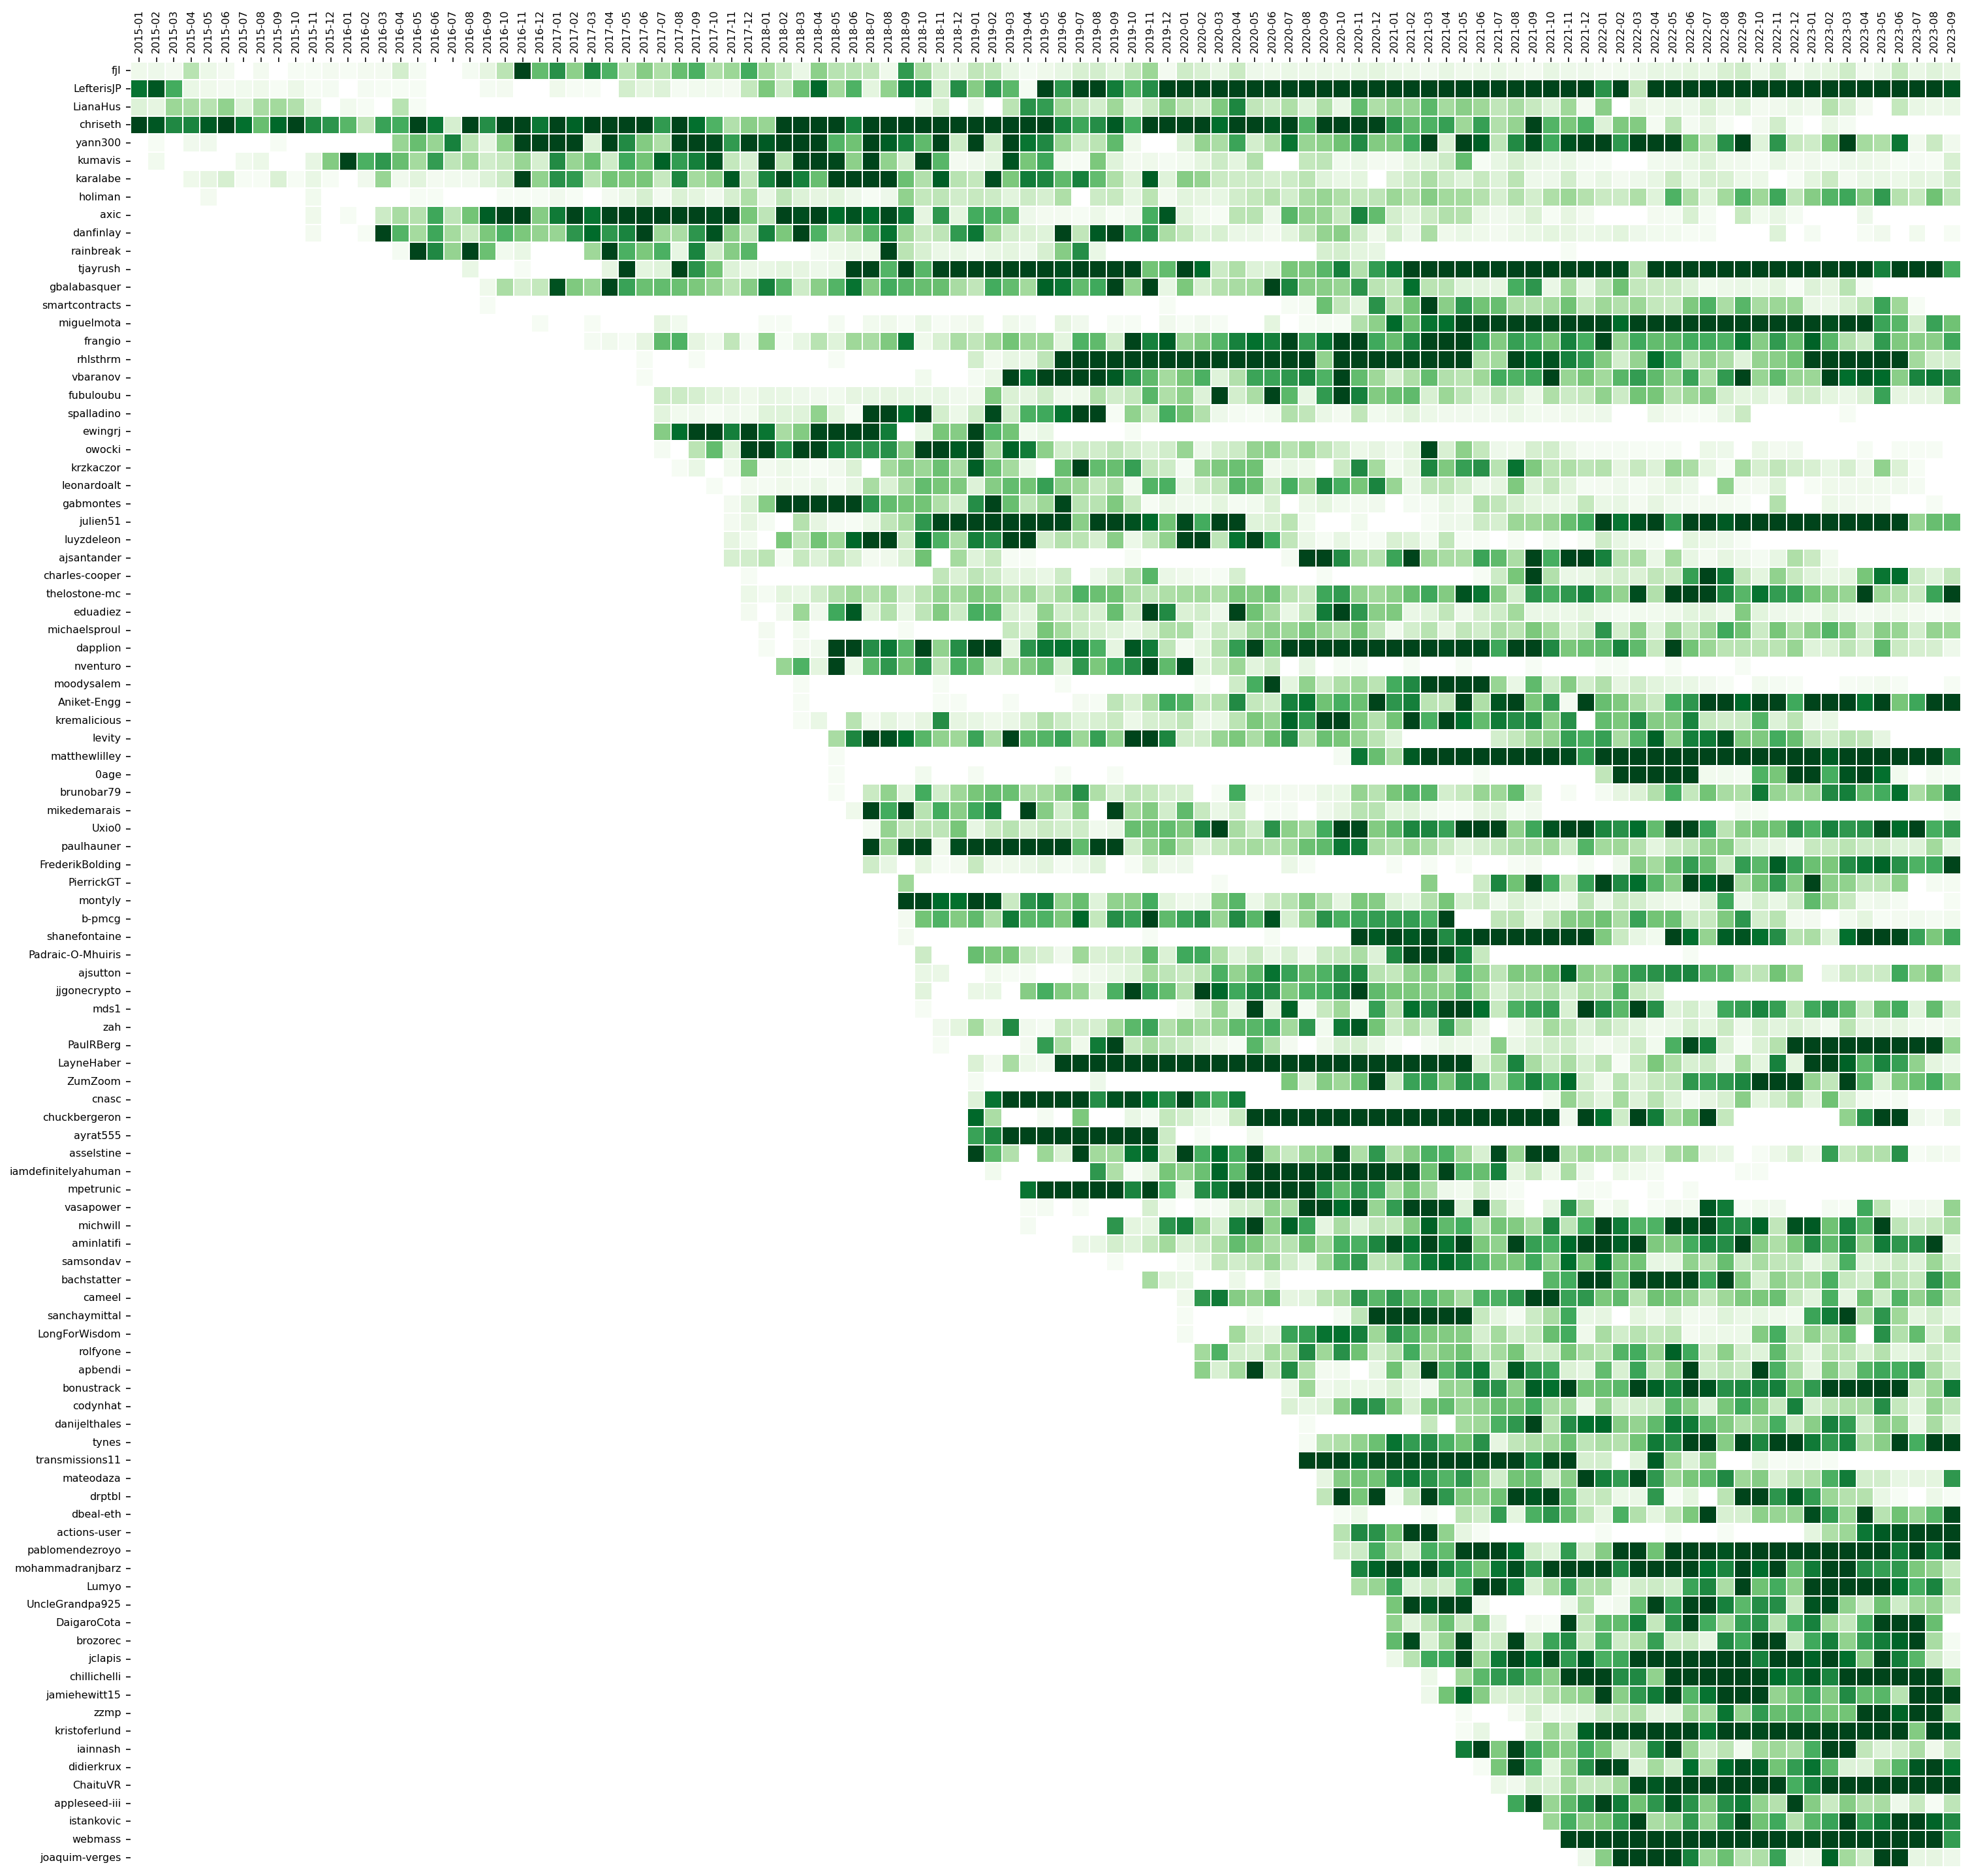

In [27]:
num_projects_contributed_to = 3
eligible_contribs = dff.groupby('contributor_name')['project_slug'].nunique()
eligible_contribs = eligible_contribs[eligible_contribs >= num_projects_contributed_to].index

top_contribs = dff[dff['contributor_name'].isin(eligible_contribs)]['contributor_name'].value_counts()
top_contribs = top_contribs.head(100).index
top_contribs = [c for c in top_contribs if "@" not in c]

contribution_heatmap(
    dff[dff.contributor_name.isin(top_contribs)],
    index_col='contributor_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=100,
    dpi=DPI
)

# Onchain trends

In [198]:
slugs_param = "','".join(slugs)

results = execute_query(f"""
    SELECT 
        p.slug AS slug, 
        a.type AS artifact_type, 
        COUNT(DISTINCT a.id) AS count_artifacts
    FROM project p
    JOIN project_artifacts_artifact paa ON p."id" = paa."projectId"
    JOIN artifact a ON paa."artifactId" = a."id"
    WHERE p.slug IN ('{slugs_param}') AND a.namespace <> 'ETHEREUM'
    GROUP BY p.slug, a.type;
""", col_names=True)

df_artifacts = pd.DataFrame(results[1:], columns=results[0])
df_artifacts.head()

slug    artifact_type  count_artifacts
0  0x-splits      EOA_ADDRESS                1
1  0x-splits     SAFE_ADDRESS                1
2  0x-splits  FACTORY_ADDRESS                4
3  0x-splits   GIT_REPOSITORY               15
4  0x-splits      NPM_PACKAGE                2

In [205]:
len(slugs)

296

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

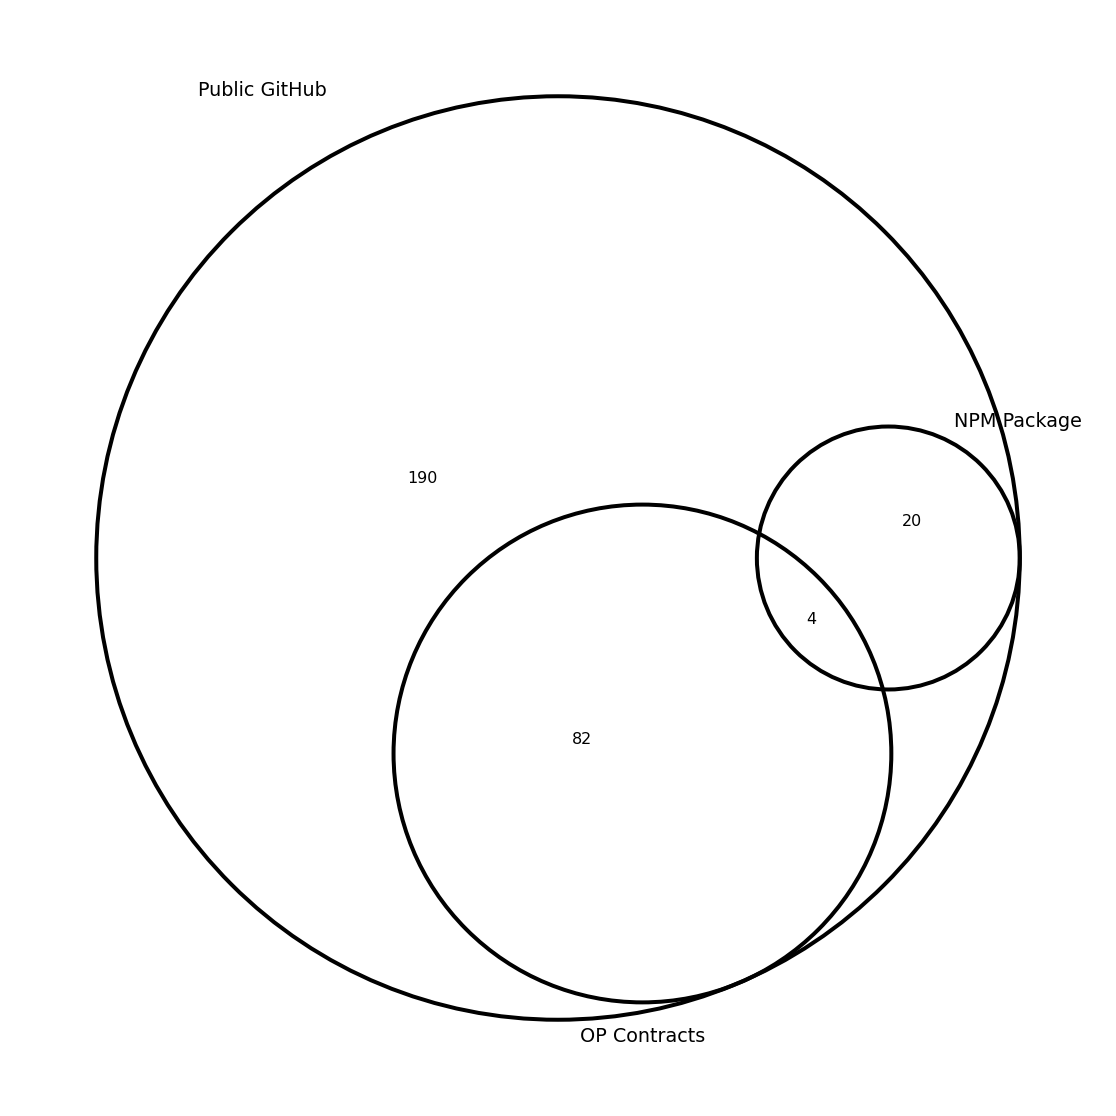

In [206]:
onchain = df_artifacts[df_artifacts['artifact_type'].isin(['FACTORY_ADDRESS', 'CONTRACT_ADDRESS'])]['slug'].unique()

venn3_diagram(
    [
        set(df_artifacts['slug'].unique()),
        set(df_artifacts[df_artifacts['artifact_type'] == 'NPM_PACKAGE']['slug'].unique()),
        set(onchain),
    ], 
    ["Public GitHub", "NPM Package", "OP Contracts"]
)

In [210]:
onchain_slugs_param = "','".join(onchain)

users_query = execute_query(f"""
    WITH Users AS (
        SELECT 
            p."slug" AS "slug",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            COUNT(DISTINCT e."fromId") AS "user_nums"
        FROM event e
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 25 -- TXN EVENTS ONLY
            AND p.slug IN ('{onchain_slugs_param}')
        GROUP BY
            p."slug",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("user_nums")
    FROM Users
    WHERE month < '{END_DATE[:-3]}'
    GROUP BY slug, month;
""", col_names=True)

df_users = pd.DataFrame(users_query[1:], columns=users_query[0])
df_users['sum'] = df_users['sum'].apply(int)
df_users.head()

slug    month sum
0  0x-splits  2022-10  19
1  0x-splits  2022-11  25
2  0x-splits  2022-12   7
3  0x-splits  2023-01   1
4  0x-splits  2023-02   3

(<Figure size 1380x4260 with 1 Axes>, <AxesSubplot:>)

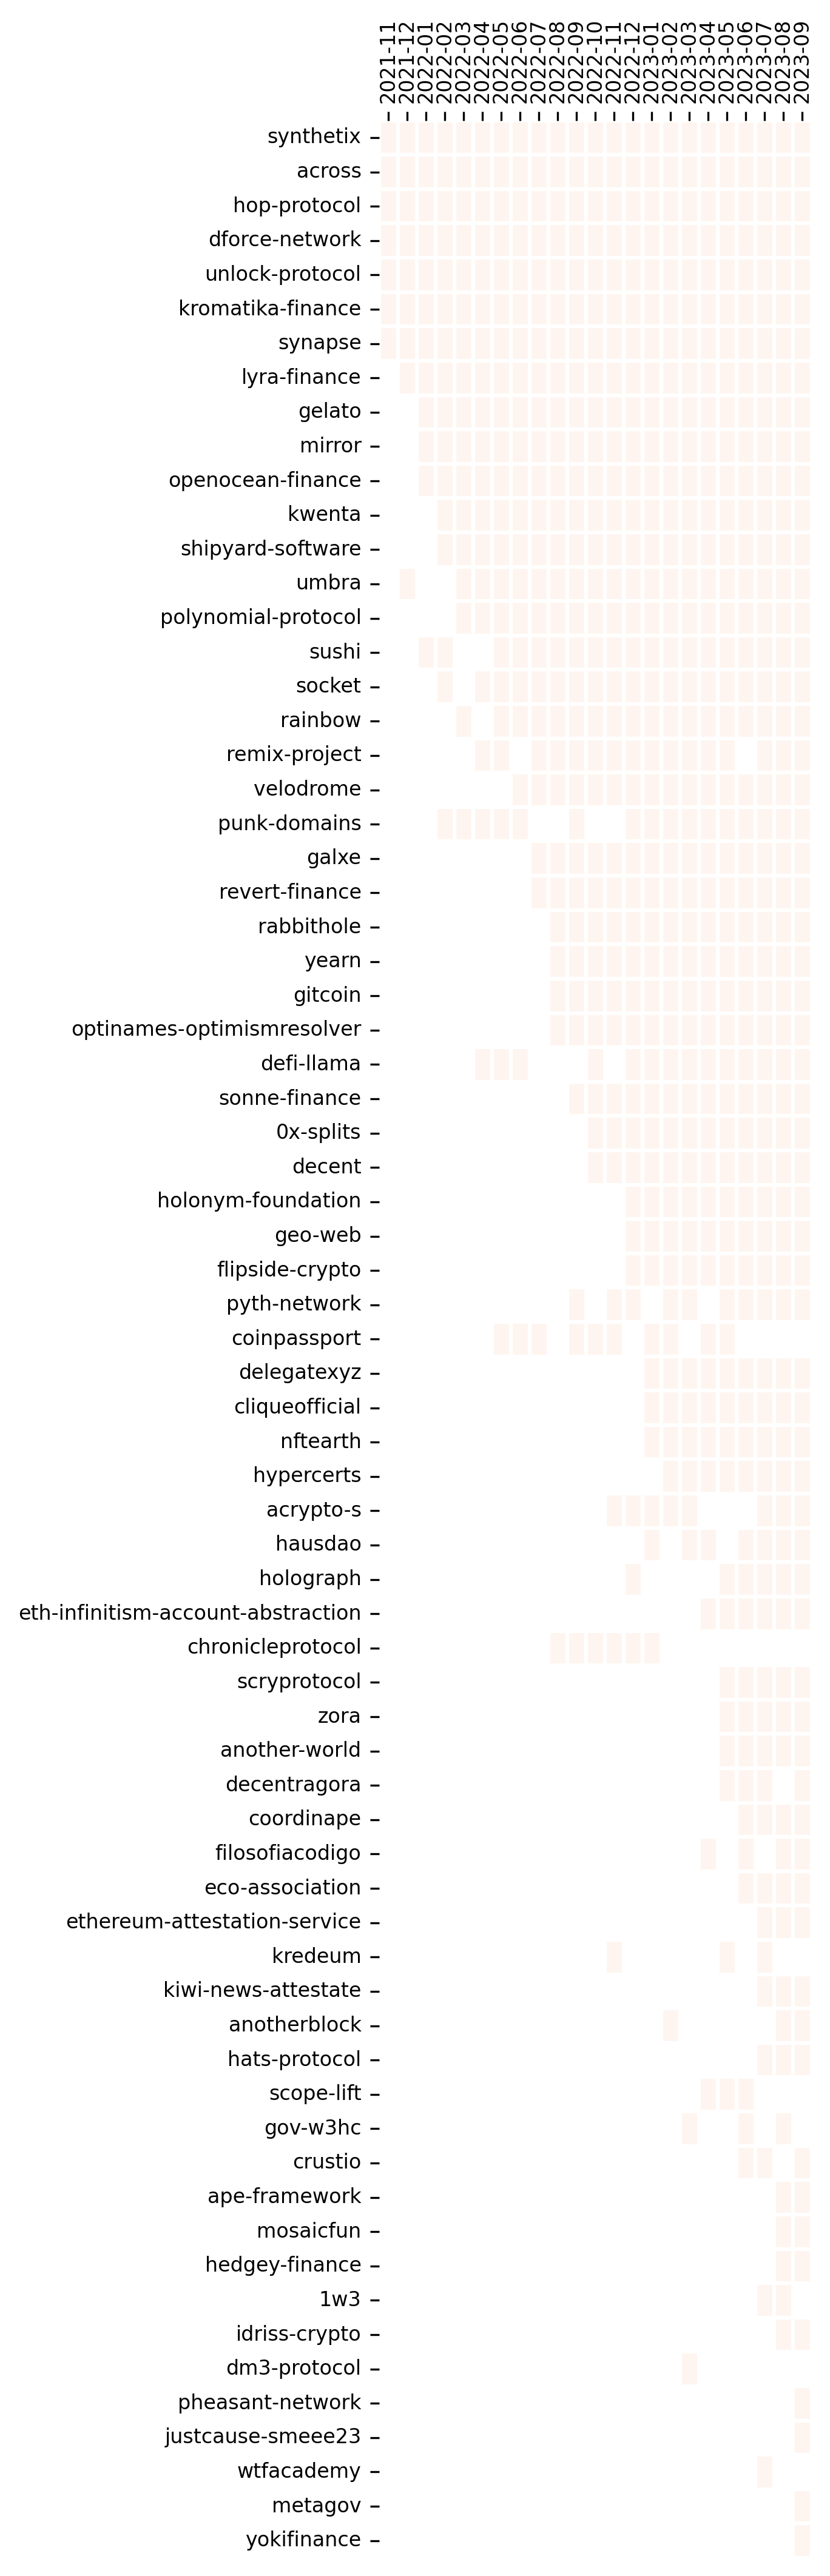

In [223]:
contribution_heatmap(
    df_users,
    index_col='slug',
    column_col='month',
    value_col='sum',
    apply_groupby=True,
    sort_label_method='mean',
    dpi=300,
    cmap='Reds'
)

<AxesSubplot:xlabel='month'>

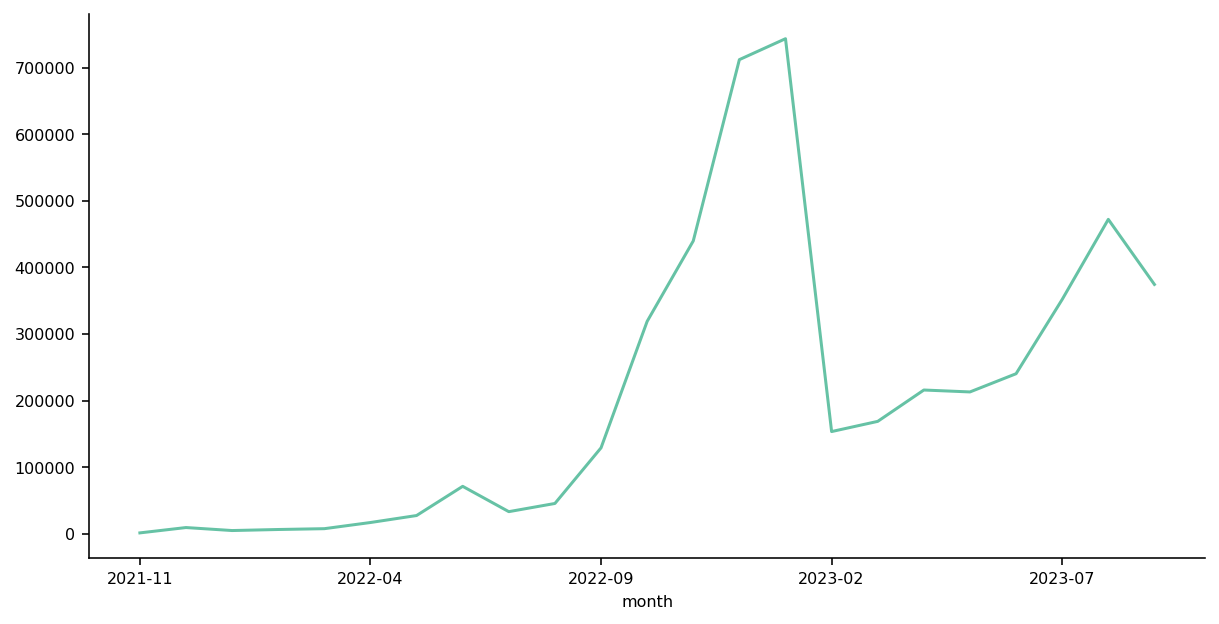

In [219]:
df_users.groupby('month')['sum'].sum().apply(int).plot()

In [220]:
df_users.sort_values(by='sum')

slug    month     sum
42           acrypto-s  2023-07       1
485       pyth-network  2023-08       1
557       scryprotocol  2023-09       1
58   chronicleprotocol  2022-11       1
556       scryprotocol  2023-08       1
..                 ...      ...     ...
724          velodrome  2022-12  132647
181              galxe  2022-11  134338
642            synapse  2022-12  141602
183              galxe  2023-01  216989
182              galxe  2022-12  230375

[755 rows x 3 columns]

(<Figure size 1440x1440 with 1 Axes>,
 <AxesSubplot:title={'center':'Projects with Common Contributors'}>)

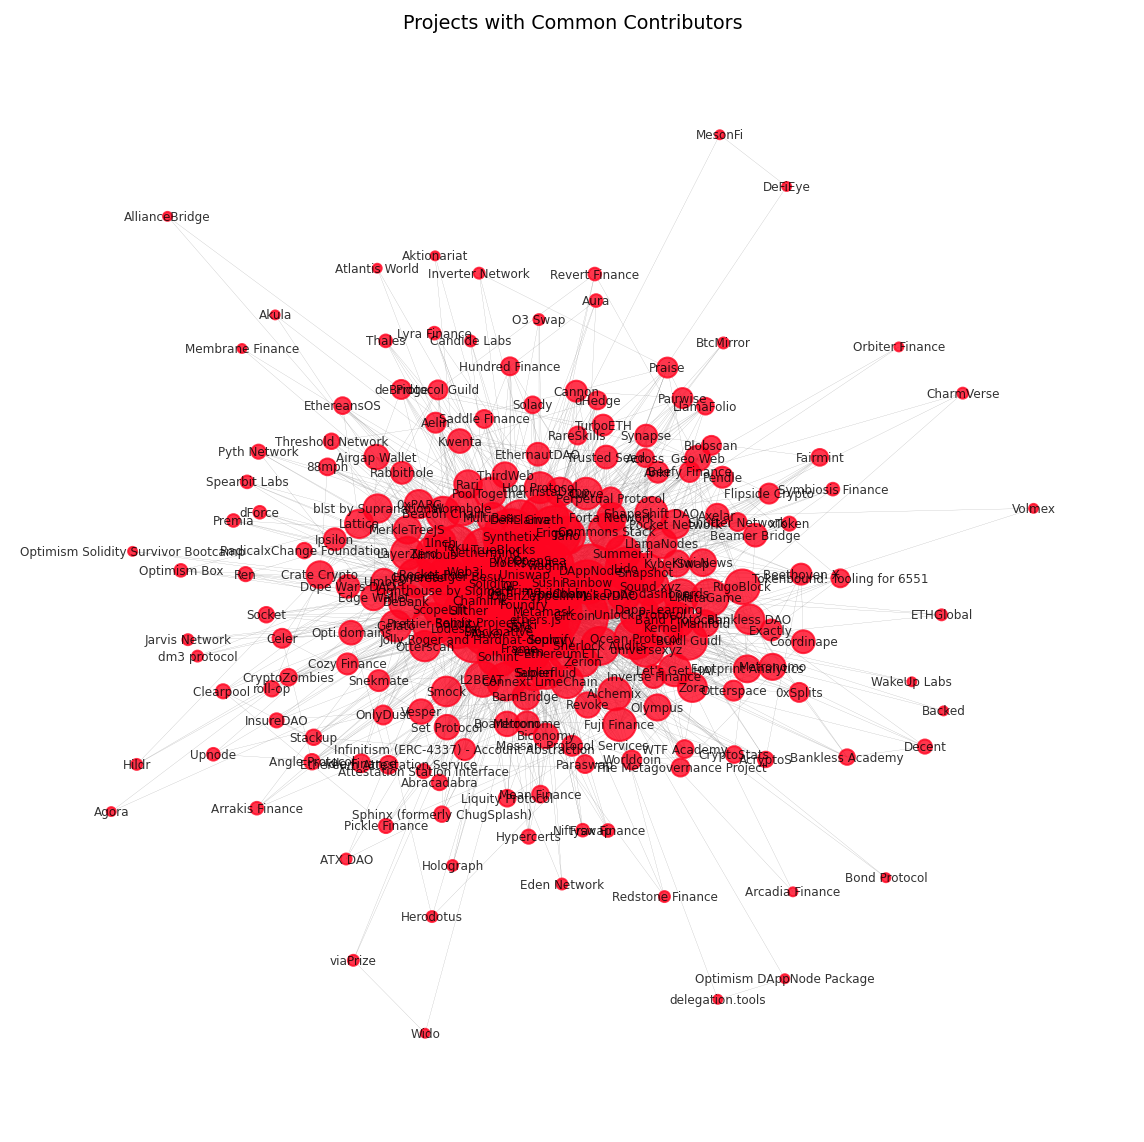

In [28]:
nodes, edges = github_network_graph(dff)
network_graph(
    nodes, edges, 
    figsize=(10,10), # looks best at (30,30)
    dpi=DPI,         # looks best at 500
    scale=1, 
    k=(3/(len(nodes)**.5)),
    min_degree=2,
    styling=dict(
        with_labels=True, 
        font_size=6, 
        font_color='black', 
        node_color='#FF0420', 
        alpha=.8,
        edge_color='grey',
        width=.1
    )
)